In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
from PIL import Image

import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border

ModuleNotFoundError: No module named 'tensorflow'

In [37]:
# Rotation: Xoay
import cv2 as cv
def rotate(img, angle, rotPoint= None):
    (height, width) = img.shape[:2]
    
    if rotPoint is None:
        rotPoint = (width/2, height/2)
        
    rotMat = cv.getRotationMatrix2D(rotPoint, angle, 1.0)
    dimensions = (width, height)
    
    return cv.warpAffine(img, rotMat, dimensions)

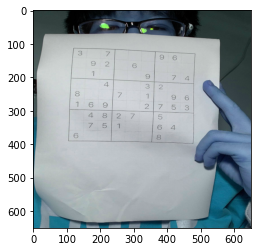

In [2]:
img = cv.imread('webcam3.jpg')
img = cv.resize(img,(650, 650))
plt.imshow(img, cmap= 'gray')

In [3]:
def get_puzzle(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), cv.BORDER_DEFAULT)
#     thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 1, 11, 2)
    thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    thresh = cv.bitwise_not(thresh)
    
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv.contourArea, reverse=True)
    # initialize a contour that corresponds to the puzzle outline
    puzzleCnt = None
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points, then we can
        # assume we have found the outline of the puzzle
        if len(approx) == 4:
            puzzleCnt = approx
            break

#     puzzle = four_point_transform(img, puzzleCnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))
    
    return (puzzleCnt, warped)

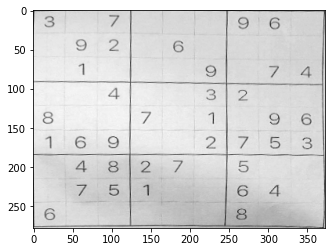

In [4]:
puzzleCnt, warped = get_puzzle(img)
plt.imshow(warped, cmap= 'gray')

In [5]:
new_model = load_model('mnist_digits.h5')

In [6]:
def prediction(image, new_model):
    classes = np.argmax(new_model.predict(image), axis= -1)
    return classes[0]

In [7]:
def getCellPositions(img_extract):
    cell_positions = []
    
    cell_width = img_extract.shape[1] // 9
    cell_height = img_extract.shape[0] // 9
    
    startX, endX, startY, endY = 0,0,0,0
    
    for i in range(9):
        endY = startY + cell_height
        startX = 0
        for j in range(9):
            endX = startX + cell_width
            current_cell = [startX, endX, startY, endY]
            cell_positions.append(current_cell)
            startX = endX
        startY = endY
    return cell_positions

In [8]:
def extract_digit(img):
    thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV| cv.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return None
    # otherwise, find the largest contour in the cell and create a
    # mask for the contour
    c = max(cnts, key=cv.contourArea)
    mask = np.zeros(thresh.shape, dtype= "uint8")
    cv.drawContours(mask, [c], -1, 255, -1)
    
    # compute the percentage of masked pixels relative to the total
    # area of the image
    (h, w) = thresh.shape
    percentFilled = cv.countNonZero(mask) / float(w * h)
    # if less than 3% of the mask is filled then we are looking at
    # noise and can safely ignore the contour
    if percentFilled < 0.022:
        return None
    # apply the mask to the thresholded cell
    digit = cv.bitwise_and(thresh, thresh, mask=mask)
    # check to see if we should visualize the masking step
    # return the digit to the calling function
    plt.imshow(digit)
    return digit

In [9]:
def predictDigit(cell, img_extract, new_model):
    img_extract = img_extract[cell[2] : cell[3], cell[0] : cell[1]]
    digit = extract_digit(img_extract)
    if digit is not None:
        # resize the cell to 28x28 pixels and then prepare the
        # cell for classification
        roi = cv.resize(digit, (28, 28))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        # classify the digit and update the Sudoku board with the
        # prediction
        result = prediction(roi, new_model)
        return result
    else:
        return 0

In [10]:
def extractSudokuDigits(img_extract, new_model):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    cell_digits, num = [], 0
    cells = getCellPositions(img_extract)
    for cell in range(len(cells)):
        num = predictDigit(cells[cell],img_extract, new_model)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)] 
    return cell_digits

[[3, 0, 7, 0, 0, 0, 5, 6, 0],
 [0, 9, 2, 0, 6, 0, 0, 0, 3],
 [1, 1, 0, 0, 0, 5, 0, 7, 1],
 [0, 0, 9, 0, 0, 3, 2, 0, 0],
 [8, 0, 0, 7, 0, 0, 0, 6, 6],
 [1, 8, 5, 0, 3, 2, 7, 5, 3],
 [0, 1, 8, 3, 7, 0, 3, 0, 0],
 [0, 7, 3, 7, 0, 0, 8, 6, 0],
 [6, 0, 0, 0, 0, 0, 8, 0, 0]]

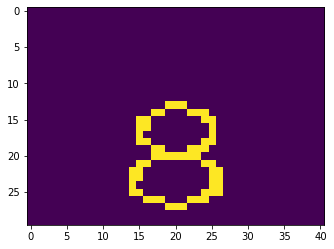

In [11]:
#testing the extraction process for one sudoku picture
a = extractSudokuDigits(warped, new_model)
a

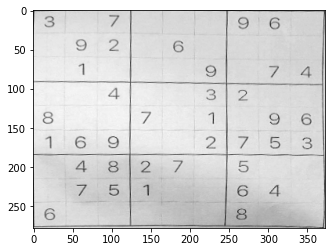

In [12]:
plt.imshow(warped, cmap= 'gray')

In [28]:
grid = ''
for i in range(9):
    for j in range(9):
        grid += str(a[i][j])
        
grid

'530070000600195000098000060800060003400803001700020006060000280000415005000080075'

## Solve Sudoku

cách giải: [link](http://norvig.com/sudoku.html)

In [14]:
def cross(A, B):
    return [a+b for a in A for b in B]

In [15]:
digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits

# Ô đơn vị 1x1: 81 ô
squares = cross(rows, cols)
# Hàng, cột, ô 3x3: 27
unitlist = ([cross(rows, c) for c in cols] + [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
# Các nhóm mà 1 ô thuộc vào, mỗi ô thuộc 3 nhóm (ngang, dọc, ô 3x3)
units = dict((s, [u for u in unitlist if s in u]) for s in squares)
# Các ô liên quan đến ô đang xét
peers = dict((s, set(sum(units[s],[]))-set([s])) for s in squares)

In [16]:
def eliminate(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminate(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
        if len(dplaces) == 0:
            return False ## Contradiction: no place for this value
        elif len(dplaces) == 1:
        # d can only be in one place in unit; assign it there
            if not assign(values, dplaces[0], d):
                return False
    return values

def assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

In [17]:
def grid_values(grid):
    "Convert grid into a dict of {square: char} with '0' or '.' for empties."
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

def parse_grid(grid):
    """Convert grid to a dict of possible values, {square: digits}, or
    return False if a contradiction is detected."""
    ## To start, every square can be any digit; then assign values from the grid.
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits and not assign(values, s, d):
            return False ## (Fail if we can't assign d to square s.)
    return values

In [18]:
def display(values):
    "Display these values as a 2-D grid."
    for s in squares:
        print(values[s])
    width = 1 + max(len(values[s]) for s in squares)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print(''.join(values[r+c].center(width)+('|' if c in '36' else '')
                      for c in cols))
        if r in 'CF':
            print(line)

In [19]:
def some(seq):
    "Return some element of seq that is true."
    for e in seq:
        if e: return e
    return False

def search(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in squares): 
        return values ## Solved!
    ## Chose the unfilled square s with the fewest possibilities
    n,s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    return some(search(assign(values.copy(), s, d)) for d in values[s])

def solve(grid):
    return search(parse_grid(grid))

In [29]:
%%time
result = list(solve(grid).values())

AttributeError: 'bool' object has no attribute 'values'

In [21]:
# board = []
# for i in range(9):
#     row = []
#     for j in range(9*i, 9*i + 9):
#         row.append(result[j])
#     board.append(row)
    
# board

In [22]:
def placeSudokuDigit(warped, grid, result):
    emptyCell = [x for x in range(len(grid)) if grid[x] == '0']
    cells = getCellPositions(warped)
    warpedCopy = warped.copy()
    for loc in emptyCell:
        x_loc = int((cells[loc][1] - cells[loc][0]) / 2) + cells[loc][0] - 10
        y_loc = cells[loc][3] - 5
        warpedCopy = cv.putText(warpedCopy, result[loc], (x_loc, y_loc),
                                cv.FONT_HERSHEY_COMPLEX_SMALL, 2, (0,255,0), 2, cv.LINE_AA)
    return warpedCopy

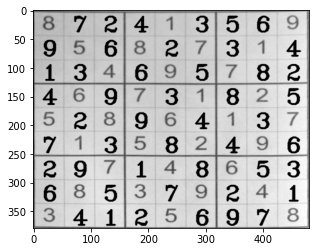

In [23]:
warpedCopy = placeSudokuDigit(warped, grid, result)
plt.imshow(warpedCopy, cmap= 'gray')

In [30]:
# #placing the valid digits for the puzzle in the empty cells and visualizing
# def placeSudokuDigits(img_PT):
#     #we start looking at the middle of the cell as this is where the sudoku digit should be at
#     img_PT = cv.resize(img_PT,(252,252)) #had to reshape the image size to fit the model shape
#     img_color = cv.resize(img,(252,252))
#     cells = getCellPositions(img_PT)
#     n = 9
#     cr = [cells[i:i+n] for i in range(0, len(cells), n)] #cr meaning cells reshaped
#     digits = extractSudokuDigits(img_PT, new_model)
#     solve(digits) 
#     for i in range(len(cr)):
#         for j in range(len(cr[i])):
#             pos = detectEmptyCell(cr[i][j],img_PT)
#             digit_text = digits[i][j]
#             if pos == []:
#                 cv.putText(img_color, str(digit_text), ((cr[i][j][0]+8),(cr[i][j][2]+19)),cv.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2, cv.LINE_AA)
#             else:
#                 continue  
#     plt.imshow(img_color,cmap='gray')